In [2]:
from pathlib import Path
from thermophysicalProperties import Database
import matplotlib.pyplot as plt
from frozendict import frozendict
import numpy as np
import warnings
from paths import THERMOCHIMICA, THERMOCHIMICA_CHLORIDE_DATA, MSTDB_TP_DATA, MSTDB_TP_RK_DATA, SALT_OPTIMIZATION

warnings.filterwarnings("ignore")

import thermoToolsAdditions as tta

db = Database(MSTDB_TP_DATA, MSTDB_TP_RK_DATA)

# Introduction
This notebook is for evaluating the final properties of the chosen coolant and fuel salts, calculating actinide solubility, and performing polynomial fits to data to get expansion coefficients for CFD calculations.

## Coolant Salt

Text(0.5, 1.0, 'Coolant Salt Viscosity')

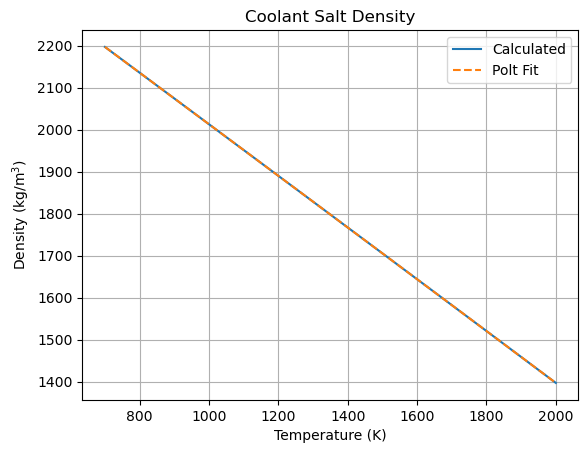

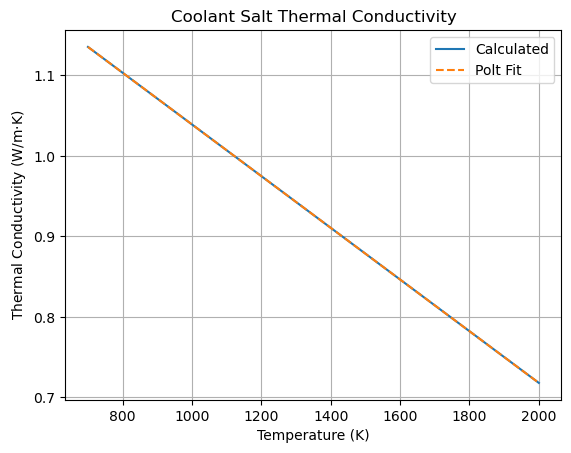

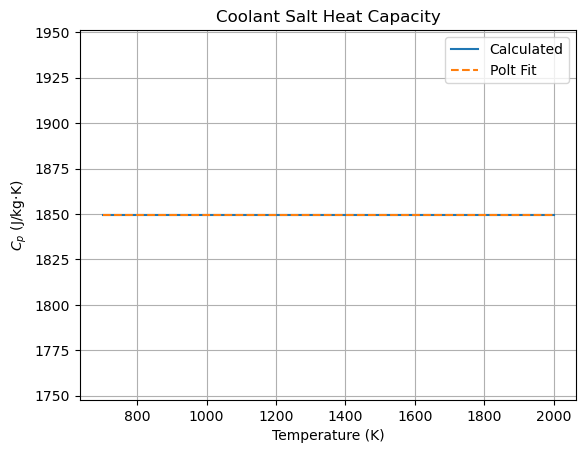

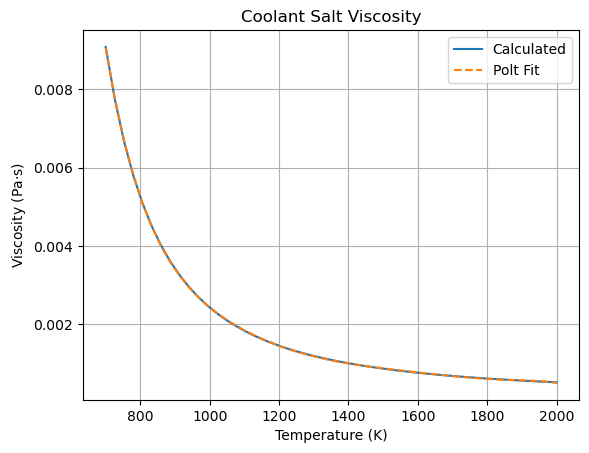

In [32]:
final_coolant_salt_composition = frozendict({'NaF': 0.132, 'ZrF4': 0.032, 'KF': 0.4109, 'LiF': 0.4251})

cool_temps = np.linspace(700, 2000)
densities = [ db.get_tp('density', final_coolant_salt_composition)(T).nominal_value for T in cool_temps ]
thermal_conductivities = [ db.get_tp('thermal_conductivity', final_coolant_salt_composition)(T).nominal_value for T in cool_temps ]
heat_capacities = [ db.get_tp('liquid_heat_capacity', final_coolant_salt_composition)(T).nominal_value for T in cool_temps ]
viscosities = [ db.get_tp('viscosity', final_coolant_salt_composition)(T).nominal_value for T in cool_temps ]

degree = 7
density_coefs = np.polyfit(cool_temps, densities, degree)
thermal_conductivity_coefs = np.polyfit(cool_temps, thermal_conductivities, degree)
heat_capacity_coefs = np.polyfit(cool_temps, heat_capacities, degree)
viscosity_coefs = np.polyfit(cool_temps, viscosities, degree)

# Now create the polynomials for plotting
density_p = np.poly1d(density_coefs)
thermal_conductivity_p = np.poly1d(thermal_conductivity_coefs)
heat_capacity_p = np.poly1d(heat_capacity_coefs)
viscosity_p = np.poly1d(viscosity_coefs)

plt.figure(1)
plt.plot(cool_temps, densities, label='Calculated')
plt.plot(cool_temps, density_p(cool_temps), linestyle='dashed', label='Polt Fit')
plt.grid()
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg/m$^3$)')
plt.title('Coolant Salt Density')

plt.figure(2)
plt.plot(cool_temps, thermal_conductivities, label='Calculated')
plt.plot(cool_temps, thermal_conductivity_p(cool_temps), linestyle='dashed', label='Polt Fit')
plt.grid()
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/m$\cdot$K)')
plt.title('Coolant Salt Thermal Conductivity')

plt.figure(3)
plt.plot(cool_temps, heat_capacities, label='Calculated')
plt.plot(cool_temps, heat_capacity_p(cool_temps), linestyle='dashed', label='Polt Fit')
plt.grid()
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('$C_p$ (J/kg$\cdot$K)')
plt.title('Coolant Salt Heat Capacity')

plt.figure(4)
plt.plot(cool_temps, viscosities, label='Calculated')
plt.plot(cool_temps, viscosity_p(cool_temps), linestyle='dashed', label='Polt Fit')
plt.grid()
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Viscosity (Pa$\cdot$s)')
plt.title('Coolant Salt Viscosity')

In [31]:
print(density_coefs[-1:0:-1])
print(thermal_conductivity_coefs[-1:0:-1])
print(heat_capacity_coefs[-1:0:-1])
print(viscosity_coefs[-1:0:-1])

[ 2.62624915e+03 -6.12287310e-01 -6.59982186e-07 -6.64646978e-11
 -1.46525762e-13  1.13518532e-16 -8.93703097e-20  4.34420323e-23
 -1.45160690e-26  2.84608587e-30]
[ 1.36035899e+00 -3.21222624e-04 -1.56903405e-15  3.37063223e-18
 -4.68755431e-21  4.41115040e-24 -2.84560740e-27  1.24303395e-30
 -3.52021663e-34  5.83836700e-38]
[ 1.84947141e+03  1.03187842e-09 -3.80570898e-12  8.19691526e-15
 -1.14223976e-17  1.07649456e-20 -6.95179950e-24  3.03886322e-27
 -8.60936939e-31  1.42808286e-34]
[ 2.57031592e+00 -1.84118251e-02  5.99116980e-05 -1.15814888e-07
  1.46732762e-10 -1.27017949e-13  7.59666138e-17 -3.09656672e-20
  8.22789176e-24 -1.28635936e-27]


## Fuel Salt

Text(0.5, 1.0, 'Fuel Salt Viscosity')

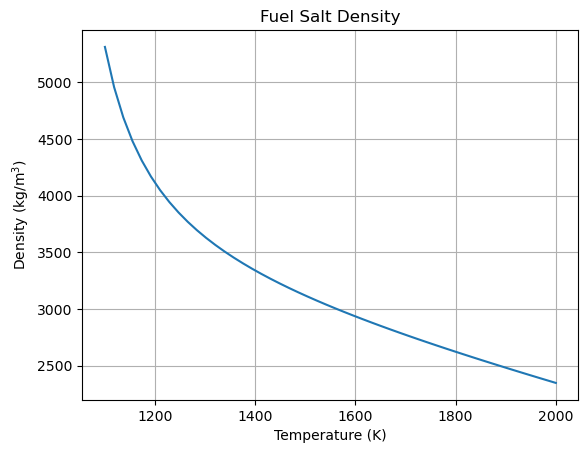

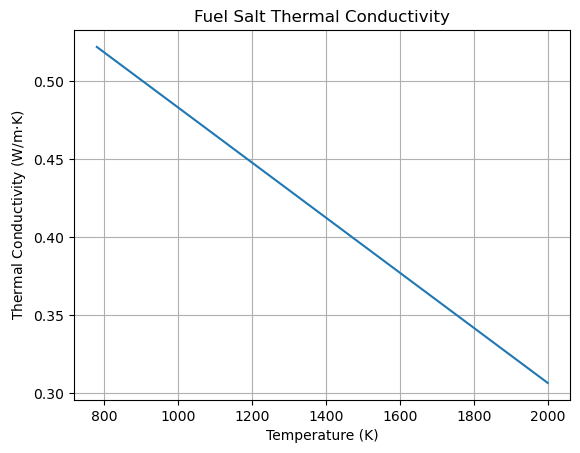

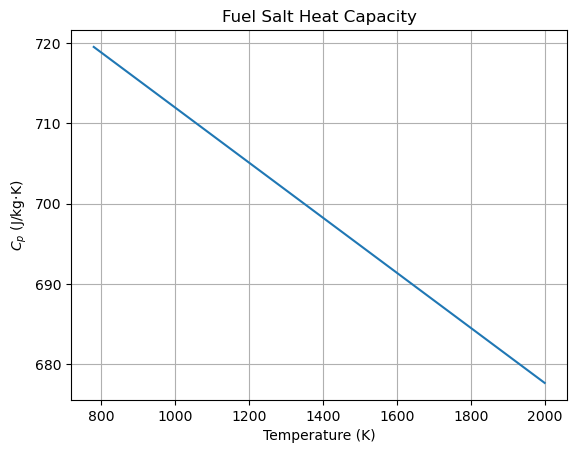

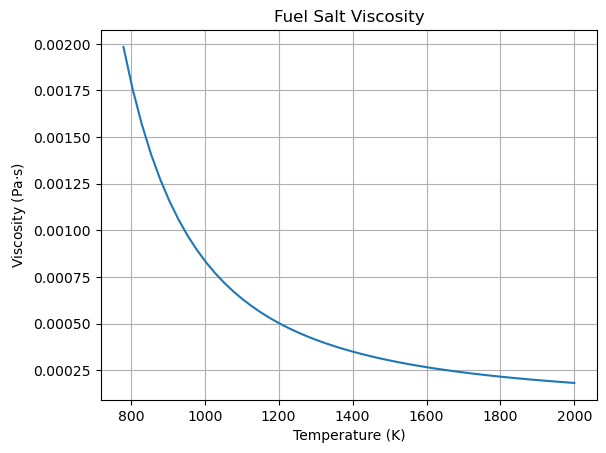

In [12]:
final_fuel_salt_composition = frozendict({'NaCl': 0.25, 'KCl': 0.141, 'ZrCl4': 0.059, 'PuCl3': 0.398, 'NdCl3': 0.002, 'UCl3': 0.15})

fuel_temps = np.linspace(1100, 2000)
densities = [ db.get_tp('density', final_fuel_salt_composition)(T).nominal_value for T in fuel_temps ]
thermal_conductivities = [ db.get_tp('thermal_conductivity', final_fuel_salt_composition)(T).nominal_value for T in cool_temps ]
heat_capacities = [ db.get_tp('liquid_heat_capacity', final_fuel_salt_composition)(T).nominal_value for T in cool_temps ]
viscosities = [ db.get_tp('viscosity', final_fuel_salt_composition)(T).nominal_value for T in cool_temps ]

plt.figure(1)
plt.plot(fuel_temps, densities)
plt.grid()
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg/m$^3$)')
plt.title('Fuel Salt Density')

plt.figure(2)
plt.plot(cool_temps, thermal_conductivities)
plt.grid()
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/m$\cdot$K)')
plt.title('Fuel Salt Thermal Conductivity')

plt.figure(3)
plt.plot(cool_temps, heat_capacities)
plt.grid()
plt.xlabel('Temperature (K)')
plt.ylabel('$C_p$ (J/kg$\cdot$K)')
plt.title('Fuel Salt Heat Capacity')

plt.figure(4)
plt.plot(cool_temps, viscosities)
plt.grid()
plt.xlabel('Temperature (K)')
plt.ylabel('Viscosity (Pa$\cdot$s)')
plt.title('Fuel Salt Viscosity')

In [5]:
db.get_tp('density', final_fuel_salt_composition)(1500).nominal_value

3118.5757216645675

In [33]:
db.get_tp('density', final_coolant_salt_composition)(850).nominal_value

2105.238031730295

# Calculating Solubility
An important constraint is actinide solubility of the fuel salt. During the salt optimization, the actinide fraction of the salt was taken from neutronic constraints as 0.55, so we need to make sure that this fraction of actinides (mainly $\text{PuCl}_3$) will be soluble in the fuel salt at the operating temperatures.

In [7]:
# File IO input parameters for thermoToolsAdditions
tta.Config.set_config(
    thermochimica_path = THERMOCHIMICA,
    output_path = SALT_OPTIMIZATION / 'thermophysicalProperties',
    data_file = THERMOCHIMICA_CHLORIDE_DATA
)

In [8]:
press = 1
tunit = 'K'
punit = 'atm'
munit = 'moles'

xlo = 0.0
xhi = 1.0
nxstep = 120
tlo = 500
thi = 1200
ntstep = 120

x1 = 1/0.45
x2 = 1/0.55
left_endmember_composition = {'Na Cl': 0.25*x1, 'K Cl': 0.141*x1, 'Zr Cl_4': 0.059*x1}
right_endmember_composition = {'Pu Cl_3': 1.0,}

elements_used = ['Cl', 'Na', 'K', 'Zr', 'Pu', 'Nd', 'U']

calc = tta.pseudo_binary_calculation(xlo, xhi, nxstep, tlo, thi, ntstep, elements_used,\
                                left_endmember_composition, right_endmember_composition)

# Now load output.json and plot

# Plot region diagram
loaded_output = tta.thermoOut(default=True)
diagram = tta.pseudoBinaryDiagram(left_endmember_composition, right_endmember_composition, default=True, \
                                plot_everything=True, ntstep=ntstep, nxstep=nxstep)
diagram.plot_phase_regions(plot_marker='.', plot_mode='region')

Thermochimica calculation initiated.
Thermochimica calculation finished.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


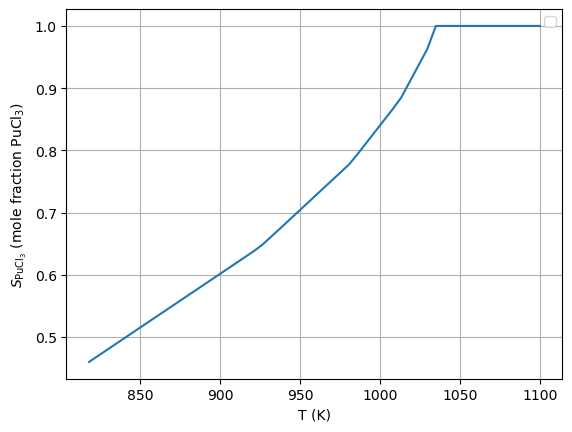

In [ ]:
temps = np.linspace(780, 1100, ntstep)
solubility = diagram.calculate_solubility(frozenset({'MSCL', 'PuCl3_P63/M_No.176(s)', 'gas_ideal'}), temps)
nonzero_indices = np.nonzero(solubility)


plt.plot(temps[nonzero_indices], solubility[nonzero_indices])
plt.xlabel('T (K)')
plt.ylabel('$S_{\\text{PuCl}_3}\\text{ (mole fraction PuCl}_3\\text{)}$')
plt.legend()
plt.grid()
plt.show()

And so we see that the given actinide fraction is soluble (though barely) in the fuel salt even at temperatures near the probable coolant inlet temperaure (850 K) which is only expected to occur possibly at the bottom of the fuel tube at the periphery, which fuel salt temperatures could theoretically match those of the coolant.